In [1]:
import itertools
import os
from collections import namedtuple

import luigi
import dill
import numpy as np
from scipy.stats import binom

from experiment_framework.helpers import AllAsymptotics, \
load_completed_AAs_into_dataframe, load_completed_CCCs_into_dataframe
from empirical_privacy import one_bit_sum, config
from experiment_framework.asymptotic_analysis import compute_bootstrapped_upper_bound

from notebook_context import *

### Run experiments

In [2]:
n = 1
p = 0.60
ds = {
    'n_trials': n, 'prob_success': p, 'gen_distr_type': 'multidim_binom',
}
asys = {
    'gen_sample_kwargs'  : {'generate_in_batch': True,
                            'x_concatenator': 'numpy.vstack'
                           },
    'fitter'             : 'knn',
    # we use random tie-breaking since the samples are discrete
    'fitter_kwargs'      : {'neighbor_method': 'gyorfi'},
    'n_docs'                : 50,
    'n_trials_per_training_set_size': 15,
    'n_max'              : 2**13,
    'validation_set_size': 2**10,
    'p'                  : 0.9,  # for bootstrap
    't'                  : 0.001  # for bootstrap
}

All = AllAsymptotics(
        gen_sample_path='empirical_privacy.one_bit_sum.GenSampleOneBitSum',
        dataset_settings=ds,
        asymptotic_settings=asys)
CCCs = [AA.requires()['CCC'] for AA in All.requires()]

/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/sit

In [3]:
# uncomment to delete outputs and dependencies to re-run the experiments
# for AA in All.requires():
#     AA.delete_outputs()
#     AA.delete_deps()

In [4]:
luigi.build([All], local_scheduler=True, workers=16, log_level='ERROR')

/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "task_process_context" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))


True

In [5]:
AAs = All.requires()
DF = load_completed_AAs_into_dataframe(AAs)
n_docs = DF.doc_ind.nunique()
DF = DF[DF.n_max==DF.n_max.max()]

---

### Compute $P(Correct)$ based on stat dist

In [6]:
from scipy.special import comb
def multidim_binom_stat_dist(p, d):
    q = 1-p
    n_combos = 2**d
    stat_dist = 0
    for k in range(d+1):
        n_combos_with_k = comb(d, k)
        p_1 = n_combos_with_k * p**k * q**(d-k)
        p_2 = n_combos_with_k * q**k * p**(d-k)
        delta_prob = np.abs(p_1 - p_2)
        stat_dist += delta_prob
    return 0.5*stat_dist
        

pc = 0.5+0.5*multidim_binom_stat_dist(p, 3)
print(pc)

0.648


In [7]:
DF[DF['upper_bound']>=pc].shape

(46, 16)

### Plot outcomes for all trials

In [8]:
configure_plotting_for_publication()


import pandas as pd

from scipy.optimize import least_squares


from experiment_framework.asymptotic_analysis import hoeffding_n_given_t_and_p, bootstrap_ci,\
    asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve
from experiment_framework.privacy_estimator_mixins import get_k

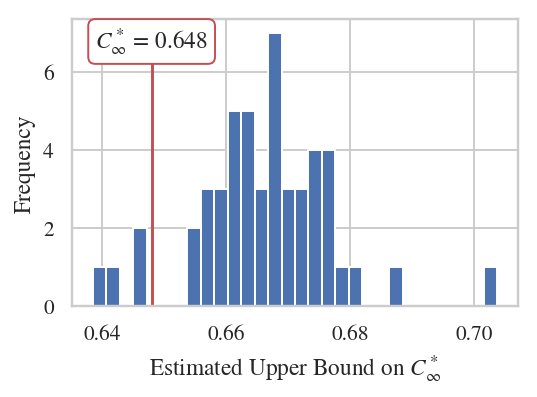

In [9]:
ax = DF.upper_bound.plot(kind='hist', bins=30)
true_ub = pc
plt.axvline(x=true_ub, color='r')
plt.text(x=true_ub,
         y=0.9,
         s='$C_\infty^*$ = {:.3f}'.format(true_ub),
         transform=x_data_y_axis(),
         horizontalalignment='center',
         bbox=dict(facecolor='w', edgecolor='r', boxstyle='round')
        )
plt.xlabel('Upper Bound on $P[$Correct$]$')
plt.title('Distribution of Upper Bounds over {ntri} trials with d={d} p={p}'.format(
    ntri=asys['n_docs'],
    d=3,
    p=p
))

if SAVE_FIGURES_FOR_LATEX:
    plt.title('')
    plt.ylabel('Frequency')
    plt.xlabel('Estimated Upper Bound on $C^*_\infty$')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, 'experiment_1_upper_bound_histogram.eps'))

### Plot the details for a single trial

In [10]:
DFccc = load_completed_CCCs_into_dataframe(CCCs)
print(DFccc.shape)

(4500, 10)


In [11]:
DFgb = DFccc.groupby(['doc_ind', 'training_set_size'], as_index=False)
DFm = DFgb.apply(lambda x: x.classifier_accuracy.max()).to_frame()
DFm.reset_index(inplace=True)
DFm = DFm.assign(classifier_accuracy_max=DFm.loc[:, 0])
DFm = DFm.drop(columns=0)

Training set sizes =  256 -- 8192
m=0.6222703709471937 C=0.09568763303033549


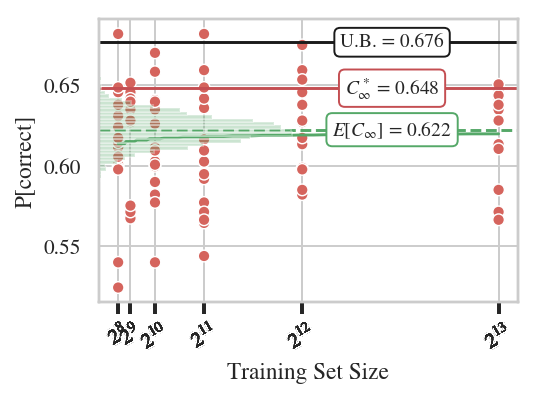

In [12]:
confidence_interval_width = 0.01
confidence_interval_prob = 0.9
    
def plot_CCC_DF(DF, doc_ind=None, d=3):
    global SAVE_FIGURES_FOR_LATEX
    print('Training set sizes = ',
          DF.training_set_size.min(),
          '--',
          DF.training_set_size.max()
         )
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
    n_docs = DF.doc_ind.nunique()
    cp = sns.color_palette('hls', n_docs, desat=0.9)
    handle = sns.scatterplot(
        data=DF,
        x='training_set_size',
        y='classifier_accuracy',
        hue='doc_ind',
        legend=None,
        palette=cp,
    
    )
   
    # curve for all the data
    d=3
    fit_model = 'gyorfi'
    x = DF.training_set_size.values.astype(np.double)
    ks = transform_n_to_k_for_knn(x, fit_model, d=d)
    y = DF.classifier_accuracy.values
    m, C = asymptotic_curve(ks, y)
    print(f'm={m} C={C}')
    
    # bootstrap for ub
    boot_res = compute_bootstrapped_upper_bound(x, d, fit_model, y,
                                 confidence_interval_prob,
                                 confidence_interval_width)
    samples = boot_res['bootstrap_samples'] 
    
    ub = boot_res['ub']
    base = config.SAMPLES_BASE
    xx = np.logspace(np.log(np.min(x))/np.log(base),
                     np.log(np.max(x))/np.log(base),
                    base=base)
    kks = transform_n_to_k_for_knn(xx, fit_model, d=d)
    plt.plot(xx, m+C*kks, '-g')
    
    labeled_axhline(ub, 'U.B.', 'k', handle)
    labeled_axhline(m, '$E[C_\infty]$', 'g', handle, linestyle='--')
    labeled_axhline(pc, '$C_\infty^*$', 'r', handle)
    
    plt.xticks(x, ['$2^{%s}$'%'{:}'.format(int(np.log(xx)/np.log(2))) for xx in x],
              rotation=30)
    
    if SAVE_FIGURES_FOR_LATEX:
        plt.xlabel('Training Set Size')
        plt.ylabel('P[correct]')
    
    ax2 = handle.twiny()
    ax2.set_xlim(0, 100.0)
    ax2.set_xticks([])
    sns.distplot(a=samples,
                 bins=30,
                 hist=True,
                 hist_kws={'alpha':0.30},
                 norm_hist=True,
                 kde=False,
                 kde_kws={'linestyle':':', 'alpha':0.75},
                 rug=False,
                 vertical=True,
                 color='g',
                ax=ax2)

    if SAVE_FIGURES_FOR_LATEX:
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_PATH, 'experiment_1_bootstrap_visualization.png'))


    
# call the function
plot_CCC_DF(DFccc, 0)
